### LOPART

In [2]:
# IMPORT
import numpy as np
import pandas as pd
from plotnine import *

In [3]:
# generate data: sequence, labels
def gen_data():
    np.random.seed(123)

    # Generate a sequence with 10 numbers
    sequence_length = 10
    sequence = np.zeros(sequence_length+1)

    means = [5, 2]                # Define the means for the 4 segments
    segment_lengths = [5, 5]      # Define the lengths of the segments

    # Populate the sequence with segments having different means
    start_index = 1
    for mean, length in zip(means, segment_lengths):
        end_index = start_index + length
        sequence[start_index:end_index] = np.random.normal(loc=mean, scale=0.2, size=length)
        start_index = end_index

    # outlier
    sequence[8] = 8

    # Labels
    neg_start = [2, 7]      # there is no changepoint at point 2, 7, and 8
    neg_end   = [3, 9]      #
    pos_start = [4]         # there can be exactly one changepoint at 4 or 5
    pos_end   = [6]         #

    return sequence, neg_start, neg_end, pos_start, pos_end

In [4]:
# Get cumulative sum vectors
def get_cumsum(sequence):
    y = np.cumsum(sequence)
    z = np.cumsum(np.square(sequence))

    y = np.append([0], y)
    z = np.append([0], z)

    return y, z

In [5]:
# function to create loss value from 'start' to 'end' given cumulative sum vector y (data) and z (square)
def L(start, end, y, z):
    _y = y[end+1] - y[start]
    _z = z[end+1] - z[start]
    return _z - np.square(_y)/(end-start+1)

In [6]:
# function to get the list of changepoint from vector tau_star
def trace_back(tau_star):
    tau = tau_star[-1]
    chpnt = np.array([len(tau_star)], dtype=int)
    while tau > 0:
        chpnt = np.append(tau, chpnt)
        tau = tau_star[tau-1]
    return np.append(0, chpnt)

In [7]:
# function to get the mean vector of the sequence from the list of changepoint
def get_mean(y, chpnt):
    mean = np.zeros(len(y)-1)
    for i in range(len(chpnt)-1):
        mean[chpnt[i]+1:chpnt[i+1]+1] = (y[chpnt[i+1]+1] - y[chpnt[i]+1])/(chpnt[i+1] - chpnt[i])
    return mean

In [8]:
# function to get T - set of possible changepoint wrt each position
def get_T(sequence_length, neg_start, neg_end, pos_start, pos_end):
    T = []
    T.append([])

    for i in range(1, sequence_length+1):
        tag = 'otherwise'
        for s, e in zip(neg_start, neg_end):
            if(s < i <= e):
                tag = 'inside region'

        for s, e in zip(pos_start, pos_end):
            if(s < i < e):
                tag = 'inside region'
            elif(i == e):
                tag = 'out positive'
                s_pos = s
                e_pos = e

        match tag:
            case "inside region":
                T.append(T[i-1])
            case "out positive":
                T.append(list(range(s_pos, e_pos)))
            case "otherwise":
                T.append(T[i-1]+[i-1])

    return T

In [9]:
# lopart dynamic algorithm return set of changepoints given lambda, T (set of possible changepoints), sequence, and cumsum vectors
def lopart(lda, T, sequence, y, z):
    sequence_length = len(sequence)-1

    # Set up
    C = np.zeros(sequence_length + 1)
    C[0] = -lda

    # Get tau_star
    tau_star = np.zeros(sequence_length+1, dtype=int)
    for t in range(1, sequence_length+1):

        # get set of possible changepoint
        po_chpnt = T[t]

        # get set of possible value
        V = np.inf * np.ones(sequence_length+1)
        for j in po_chpnt:
            V[j] = C[j] + lda + L(j+1, t, y, z)

        # get optimal tau from set V
        last_chpnt = np.argmin(V)

        # update C_i
        C[t] = V[last_chpnt]

        # update tau_star
        tau_star[t] = last_chpnt

    # get set of changepoints
    set_of_chpnt = trace_back(tau_star[1:])

    return set_of_chpnt

In [10]:
# counting errors
def count_items_between(lst, a, b):
    count = sum(1 for item in lst if a <= item < b)
    return count

def error_count(chpnt, neg_start, neg_end, pos_start, pos_end):
    fp_count, fn_count = 0, 0                           # initizlize false positive and false negative

    for s, e in zip(neg_start, neg_end):
        if(count_items_between(chpnt, s, e) > 0):       # number of change is not 0 in negative labels
            fp_count += 1

    for s, e in zip(pos_start, pos_end):
        if(count_items_between(chpnt, s, e) > 1):       # number of change is greater than 1 in positive labels
            fp_count += 1
        elif(count_items_between(chpnt, s, e) == 0):    # number of change is 0 in positive labels
            fn_count += 1

    return fp_count, fn_count

In [11]:
# function to plot sequence with labels and changepoints wrt lambda (if provided)
def plot_sequence(sequence, neg_start, neg_end, pos_start, pos_end, chpnt=None, mean=None, lda=None):
    sequence = sequence[1:]

    # Prepare data for plotnine
    data = pd.DataFrame({'point': range(1, len(sequence)+1), 'value': sequence})

    # Create the plot
    plot = (
        ggplot(data, aes(x='point', y='value')) +
        theme_minimal() +
        labs(x='point', y='value') +
        xlim(0, len(sequence) + 1) +
        ylim(np.min(sequence) - 1, np.max(sequence) + 1)
    )

    # Add negative regions
    for start, end in zip(neg_start, neg_end):
        plot += geom_rect(aes(xmin=start, xmax=end, ymin=np.min(sequence) - 1, ymax=np.max(sequence) + 1),
                          fill='pink', alpha=0.2, color='black', size=0)

    # Add positive regions
    for start, end in zip(pos_start, pos_end):
        plot += geom_rect(aes(xmin=start, xmax=end, ymin=np.min(sequence) - 1, ymax=np.max(sequence) + 1),
                          fill='red', alpha=0.2, color='black', size=0)

    # Add data points
    plot += geom_point(color='blue', size=2, alpha=0.7)

    # Add mean line
    if mean is not None:
        mean = mean[1:]
        for i in range(len(chpnt) - 1):
            plot += geom_segment(aes(x=chpnt[i]+0.5, y=mean[chpnt[i]], xend=chpnt[i+1]+0.5, yend=mean[chpnt[i]]),
                            color='green', size=1, alpha=0.7)
    # Add changepoint
    if chpnt is not None:
        for i in range(1, len(chpnt)-1):
            plot += geom_vline(xintercept=chpnt[i]+0.5, linetype='dashed', color='deepskyblue', alpha=0.8)

    # Set the figure title
    if lda is not None:
        plot += ggtitle('lambda = ' + str(lda))

        # Center the title horizontally
        plot += theme(plot_title=element_text(hjust=0.5))

    # Add legend
    plot += labs(color="Legend")  # Legend title
    plot += guides(color=guide_legend(title="Legend"))  # Legend label

    # return the plot
    return plot

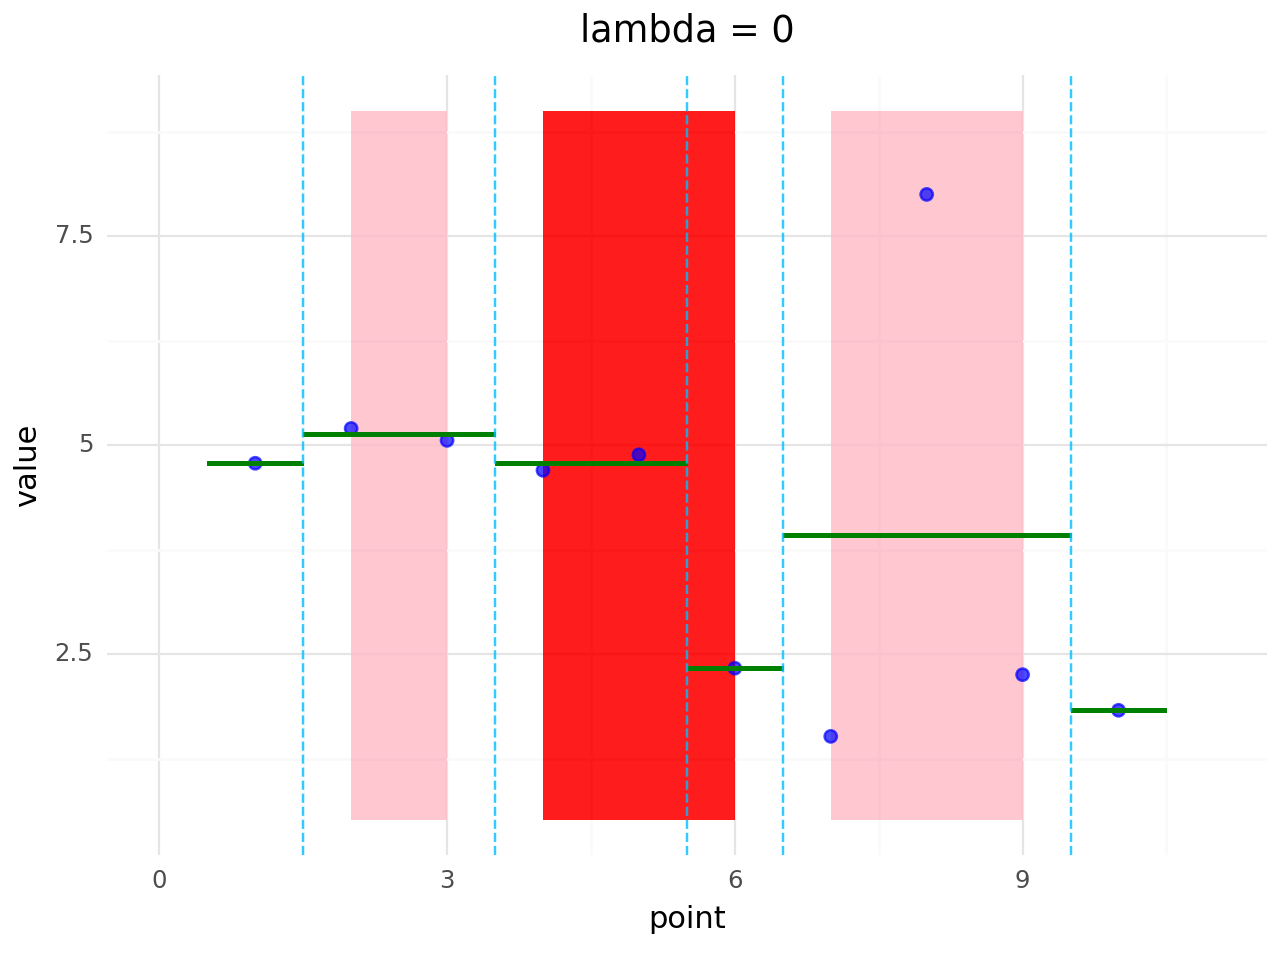

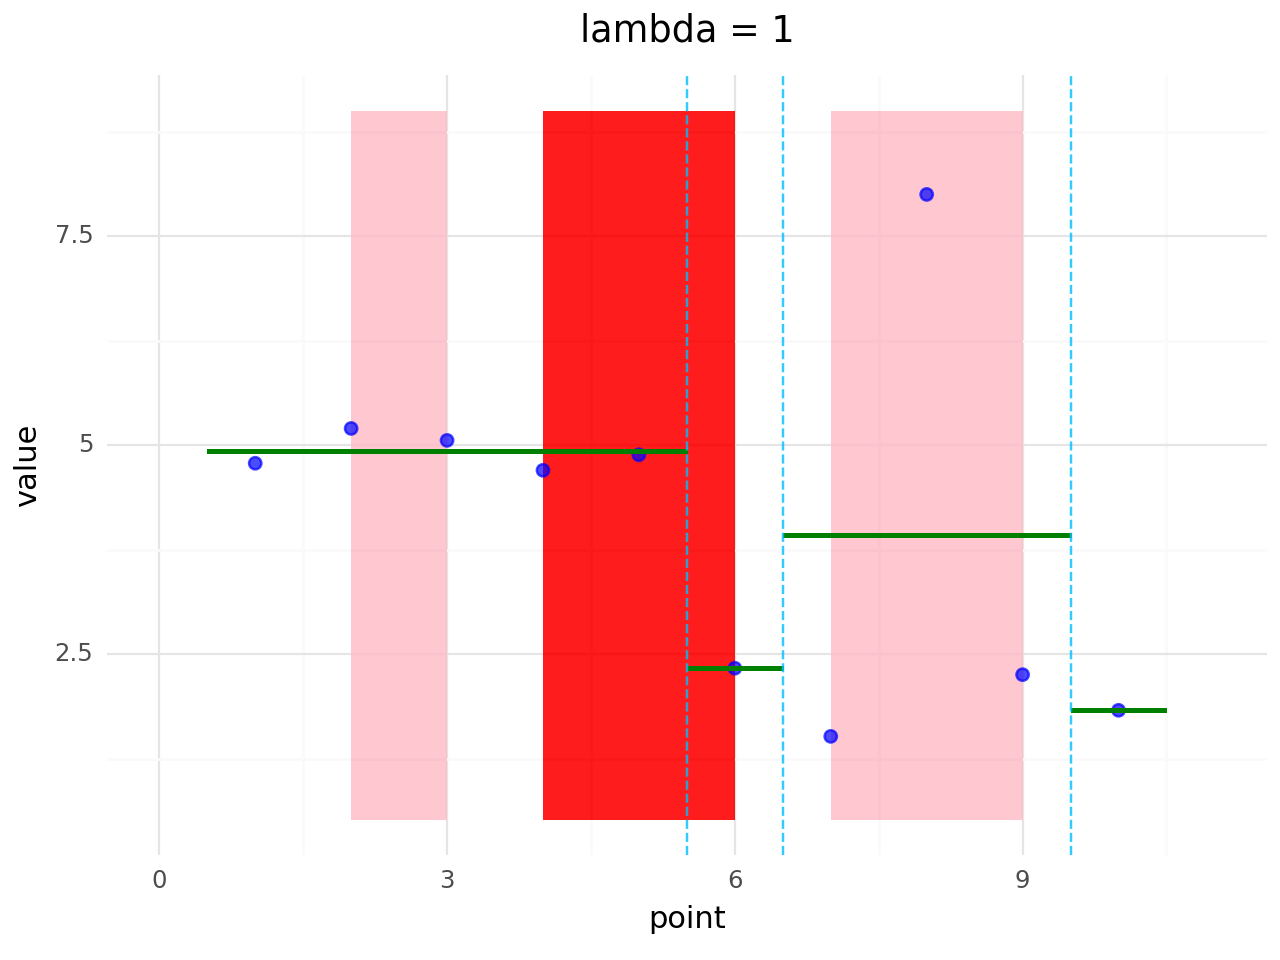

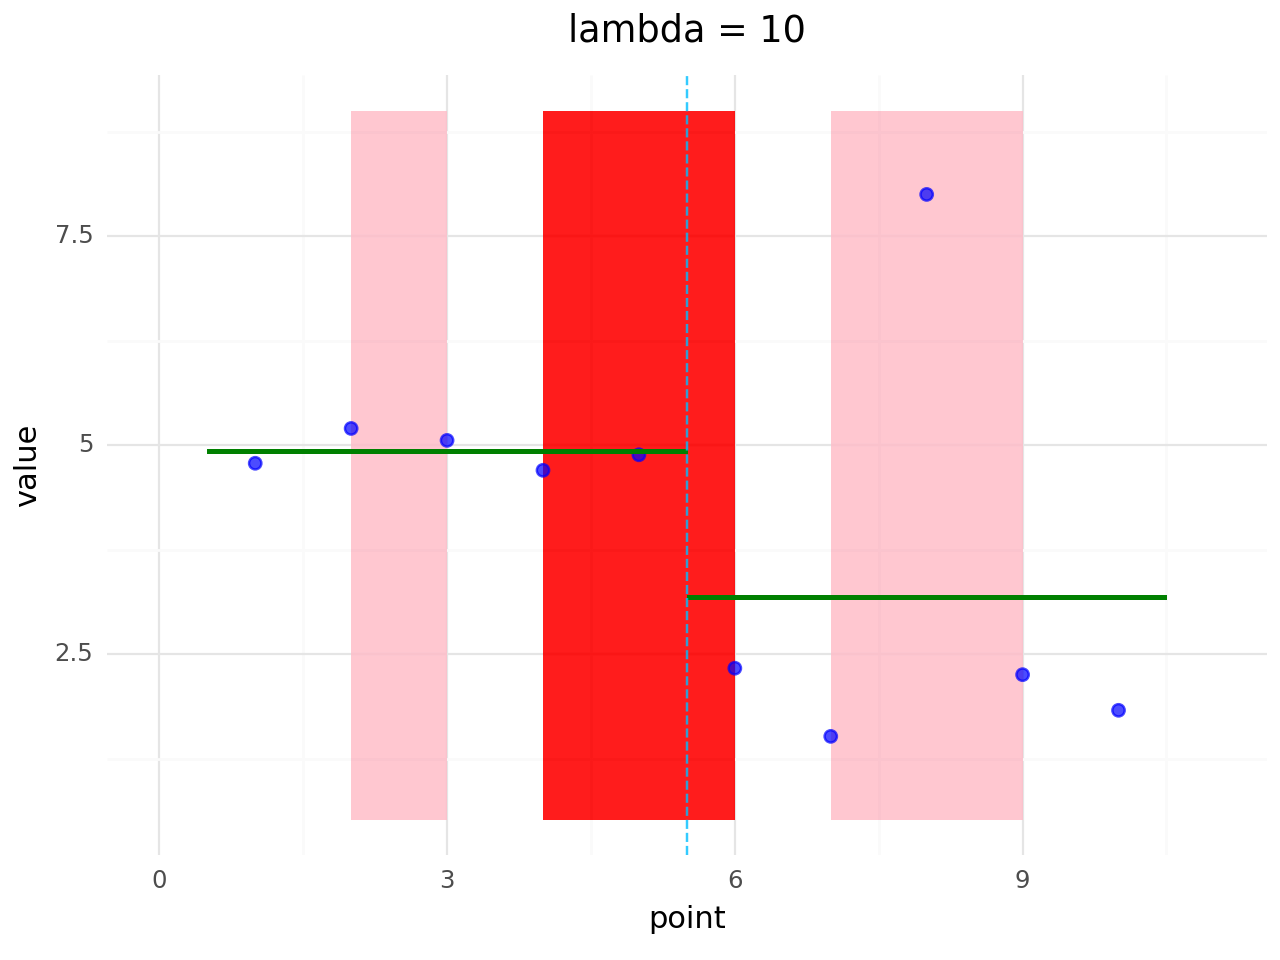

In [12]:
# generate data
sequence, neg_start, neg_end, pos_start, pos_end = gen_data()
sequence_length = len(sequence)-1

# vectors of cumulative sums
y, z = get_cumsum(sequence)

# get T
T = get_T(sequence_length, neg_start, neg_end, pos_start, pos_end)

# save images of solution with respect to different lambda into one pdf file
for lda in [0, 1, 10]:
    chpnt = lopart(lda, T, sequence, y, z)
    mean  = get_mean(y, chpnt)

    # show the plot
    print(plot_sequence(sequence, neg_start, neg_end, pos_start, pos_end, chpnt, mean, lda))

### DATA

In [13]:
import gzip

In [15]:
file_path = 'data/signals.gz'
with gzip.open(file_path, 'rt') as file:
    signal_df = pd.read_csv(file)

seqs = tuple(signal_df.groupby('sequenceID'))

In [16]:
file_path = 'data/labels.gz'
with gzip.open(file_path, 'rt') as file:
    labels_df = pd.read_csv(file)

labels = tuple(labels_df.groupby('sequenceID'))

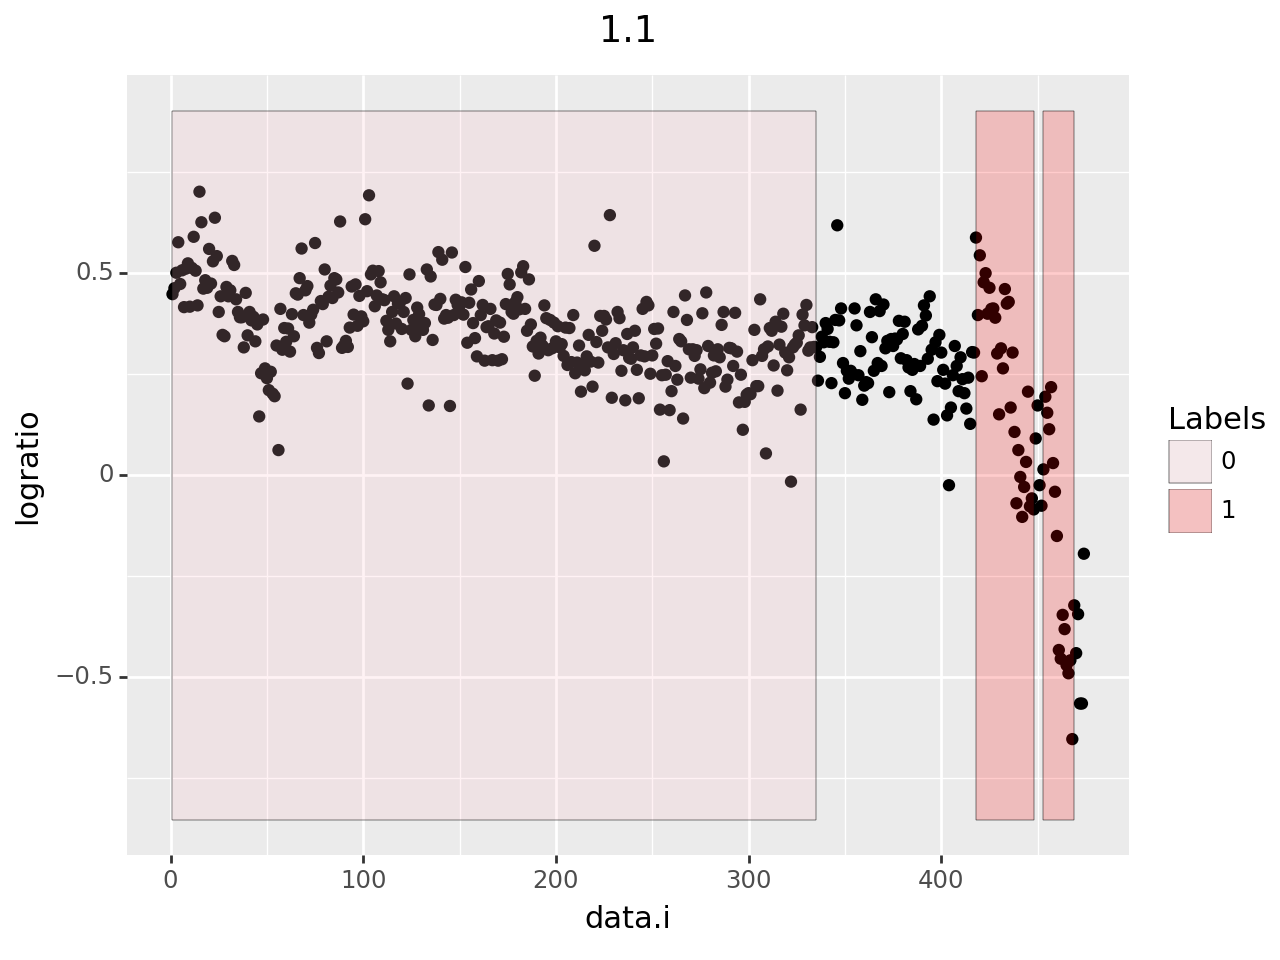

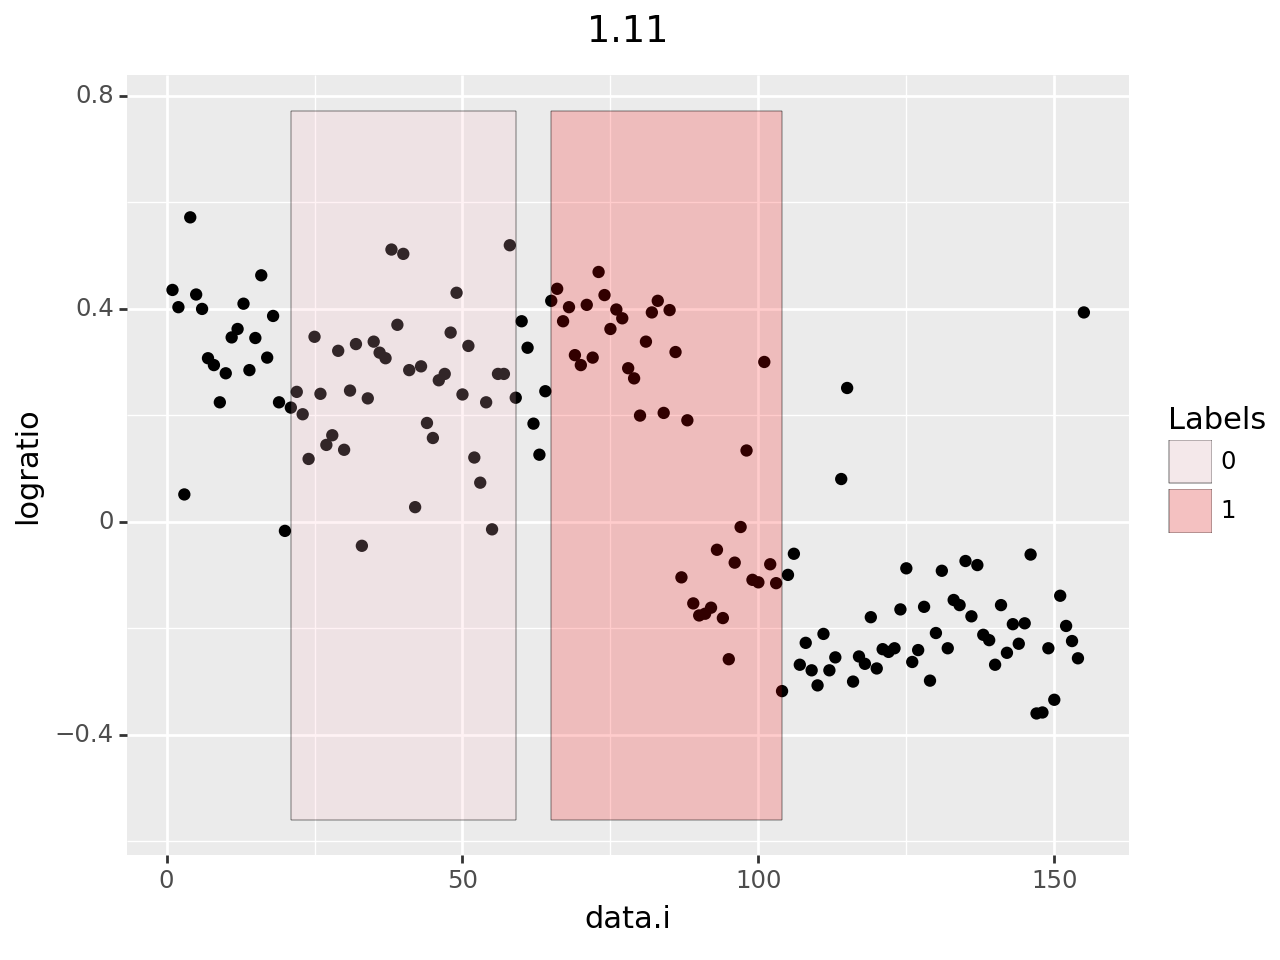

In [17]:
for i in range(2):
    seq_df = seqs[i][1]
    lab_df = labels[i][1]

    # Create a scatter plot
    plot = ggplot()
    plot += geom_point(seq_df, aes(x='data.i', y='logratio'))

    # Create rectanles
    plot += geom_rect(lab_df, aes(xmin='start', xmax='end', ymin=seq_df['logratio'].min() - 0.2, ymax=seq_df['logratio'].max()+0.2, fill='factor(changes)'), alpha=0.2, color='black', size=0.1)
    plot += scale_fill_manual(values={0: 'pink', 1: 'red'})

    # Create title
    plot += ggtitle(str(seqs[i][0]))
    plot += labs(fill='Labels')
    plot += theme(plot_title=element_text(hjust=0.5))

    # Display the plot
    print(plot)